In [1]:
import sys

# Add the parent directory to sys.path
sys.path.append('../')

from src.preprocess.preprocess import ReadAndLoadMnistData
from src.preprocess.preprocess import plot_images

import numpy as np
import matplotlib.pyplot as plt
#matplotlib inline
import keras
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, recall_score
import pandas as pd
import pickle

# Function to build model, required for KerasClassifier
def build_model(optimizer='adam', init='glorot_uniform'):
    model = Sequential()
    model.add(Input(shape=(784,)))
    model.add(Dense(units=128, activation='relu', kernel_initializer=init))
    model.add(Dropout(0.10))
    model.add(Dense(units=128, activation='relu', kernel_initializer=init))
    model.add(Dropout(0.25))
    model.add(Dense(units=10, activation='softmax', kernel_initializer=init))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    plot_model(model, to_file='fcnn_model_gridsearchcv2.png', show_shapes=True, show_layer_names=True)
    return model

class FCNNTrainAndPredict:
    
    def __init__(self, input_shape, X_train, y_train, X_test, y_test):
        print("FCNNTrainAndPredict: __init__")
        np.random.seed(0)
        self.initialize()
        self.input_shape = input_shape
        self.init_data(X_train, y_train, X_test, y_test)
        self.one_hot_encode()

    def initialize(self):
        self.fcnn_model = None
        self.best_model = None
        self.best_params = None
        self.best_accuracy = 0.0
        self.best_score = 0.0
        self.best_recall = 0.0

    def init_data(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test

    def one_hot_encode(self):
        num_classes = 10
        # self.y_train = keras.utils.to_categorical(self.y_train, num_classes)
        # self.y_test = keras.utils.to_categorical(self.y_test, num_classes)
        # Alternative: Ensure y_train is already integers
        self.y_train = np.array(self.y_train).astype(int)
        self.y_test = np.array(self.y_test).astype(int)
        print(self.y_train)
        print(self.X_train) 
    
    def train(self):
        print("FCNNTrainAndPredict: train")
        # Create the KerasClassifier
        keras_model = KerasClassifier(model=build_model, verbose=1, init='glorot_uniform')
        
        # Define the grid search parameters
        param_grid = {
            'batch_size': [32, 64, 128],
            'epochs': [5, 10],
            'optimizer': ['adam', 'rmsprop']
        }
        
        # Create GridSearchCV with error_score='raise'
        grid = GridSearchCV(estimator=keras_model, param_grid=param_grid, n_jobs=-1, cv=3, error_score='raise')
        
        # Fit the grid search
        grid_result = grid.fit(self.X_train, self.y_train)
        
        if self.fcnn_model is not None:
            plot_model(self.fcnn_model, to_file='fcnn_model_gridsearchcv2.png', show_shapes=True, show_layer_names=True)            
            
        return grid_result
    
    def evaluate(self, grid_result):
        print("FCNNTrainAndPredict: evaluate")        
        
        # Get the best model
        self.best_model = grid_result.best_estimator_
        self.best_score = grid_result.best_score_
        self.best_params = grid_result.best_params_

        # Make predictions
        y_pred = self.best_model.predict(self.X_test)
        y_pred_proba = self.best_model.predict_proba(self.X_test)
        
        # Summarize results
        # Assuming grid_result is the result of GridSearchCV
        cv_results = grid_result.cv_results_        
        # Convert the cv_results_ dictionary into a DataFrame
        cv_results_df = pd.DataFrame(cv_results)        
        # Save the DataFrame to a CSV file
        cv_results_df.to_csv('cv_results.csv', index=False)
        # Display the entire DataFrame
        print(cv_results_df)

        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params = grid_result.cv_results_['params']
        for mean, stdev, param in zip(means, stds, params):
            print("%f (%f) with: %r" % (mean, stdev, param))

        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        
        # Calculate accuracy and log loss
        test_acc = accuracy_score(self.y_test, y_pred)
        test_loss = log_loss(self.y_test, y_pred_proba)
        print("Test Loss: {}, Test Accuracy: {}".format(test_loss, test_acc))

        # Calculate ROC AUC score and recall score
        roc_auc = roc_auc_score(self.y_test, y_pred_proba, multi_class='ovr')
        recall = recall_score(self.y_test, y_pred, average='macro')
        print("ROC AUC Score: {}".format(roc_auc))
        print("Recall Score: {}".format(recall))

    
    def train_and_evaluate(self):
        print("FCNNTrainAndPredict: train_and_evaluate")
        grid_result = self.train()
        self.evaluate(grid_result)
        self.save_model()

    def save_model(self, filename="best_fcnn_model.pkl"):
        """Saves the trained model to a pickle file"""
        if self.best_model is None:
            raise Exception("No trained model found to save.")
        with open(filename, "wb") as f:
            pickle.dump(self.best_model, f)
        print(f"Model saved as {filename}")

    @staticmethod
    def load_model(filename="best_fcnn_model.pkl"):
        """Loads a trained model from a pickle file"""
        if not os.path.exists(filename):
            raise Exception(f"Model file {filename} not found!")
        with open(filename, "rb") as f:
            model = pickle.load(f)
        print(f"Model loaded from {filename}")
        return model
        
    def get_best_params(self):
        print("FCNNTrainAndPredict: get_best_params")
        if self.best_params is None:
            raise Exception("Model not trained yet")
        return self.best_params
    
    def predict(self, X):
        print("FCNNTrainAndPredict: predict")
        if self.best_model is None:
            raise Exception("Model not trained yet")
        return self.best_model.predict(X)

if __name__ == "__main__":
    # Using the ReadAndLoadMnistData class defined in the notebook
    train_file = "../dataset/mnist_train.csv"
    test_file = "../dataset/mnist_test.csv"
    
    with ReadAndLoadMnistData(train_file, test_file) as minst_data:
        X_train, y_train, X_test, y_test = minst_data.load_data()
        # Normalize the images
        X_train = X_train / 255.0
        X_test = X_test / 255.0
        
        # Example usage:
        fcnn = FCNNTrainAndPredict(28 * 28, X_train, y_train, X_test, y_test)
        fcnn.train_and_evaluate()

FCNNTrainAndPredict: __init__
[0 4 1 ... 5 6 8]
         0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  ...  0.608  0.609  \
0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   
2      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   
3      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   
4      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...    ...    ...   
59994  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   
59995  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   
59996  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   
59997  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   
59998  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   

       0.610  0

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,282 (462.04 KB)

 Trainable params: 118,282 (462.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8483 - loss: 0.4968
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9576 - loss: 0.1394
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9689 - loss: 0.1009
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9746 - loss: 0.0800
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9793 - loss: 0.0639
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9822 - loss: 0.0554
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9836 - loss: 0.0509
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9847 - loss: 0.0460
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9869 - loss: 0.0416
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9869 - loss: 0.0392
FCNNTrainAndPredict: evaluate
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
    mea

In [3]:
fcnn

In [4]:
fcnn.get_best_params()

FCNNTrainAndPredict: get_best_params


{'batch_size': 32, 'epochs': 10, 'optimizer': 'adam'}

In [ ]:
y_pred_ = fcnn.predict(X_test)

# Print the shape of the predicted labels
# Decode one-hot encoded labels
decoded_labels = np.argmax(y_pred_)

# Print the decoded labels
print(decoded_labels)
print(decoded_labels.shape)

FCNNTrainAndPredict: predict
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
6
()


In [14]:
type(X_test)

pandas.core.frame.DataFrame

Text(0.5, 1.0, 'Confusion Matrix')

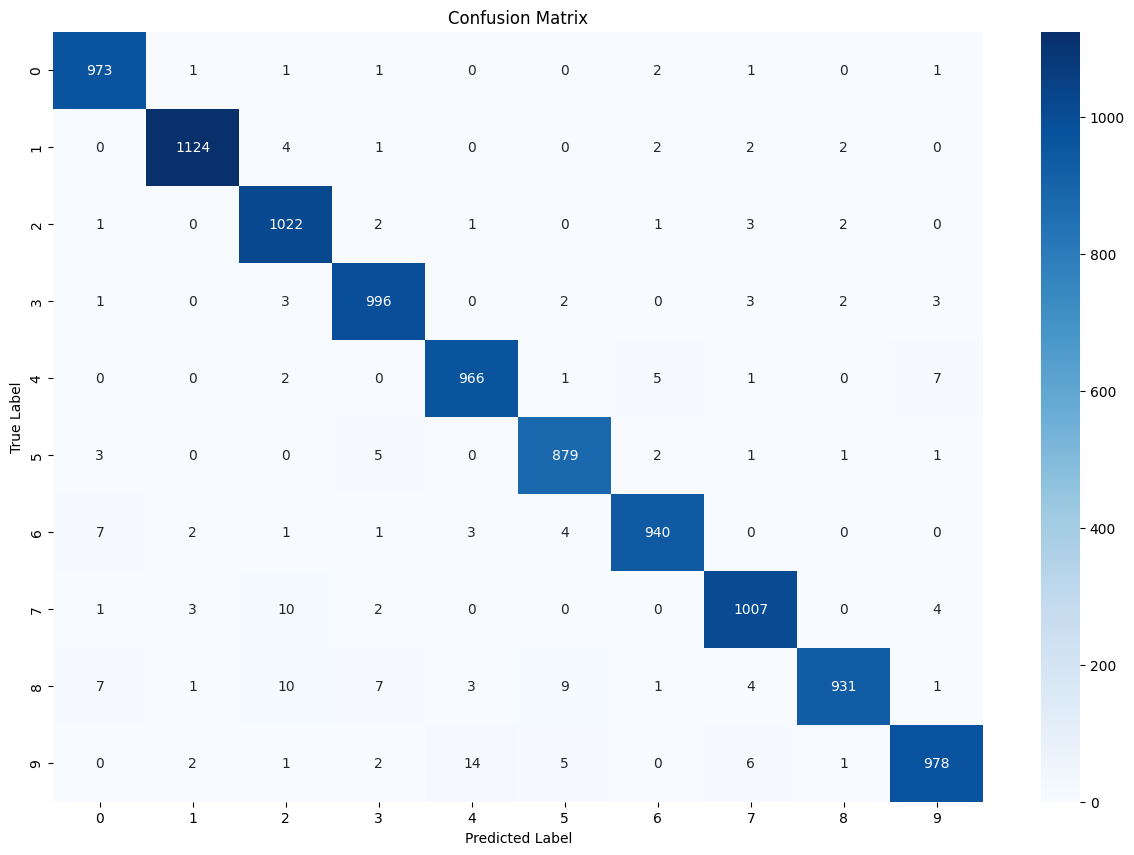

In [ ]:
confusion_mtx = confusion_matrix(y_test, y_pred_proba)

# Plot
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(confusion_mtx, annot=True, fmt='d', ax=ax, cmap="Blues")
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix')

In [ ]:
y_pred_classes = np.argmax(y_pred, axis=1)